In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Настройки отображения
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [3]:
# Загрузка файла
orders = pd.read_csv('orders.csv', parse_dates=['created_at', 'put_at', 'closed_at'])
payments = pd.read_csv('payments.csv', parse_dates=['paid_at'])
plan = pd.read_csv('plan.csv', parse_dates=['plan_at'])


In [5]:
# Сгруппируем фактические платежи по order_id и дате
payments_grouped = payments.groupby(['order_id', 'paid_at'])['paid_sum'].sum().reset_index()

# Рассчитаем накопительный платеж по дате
payments_grouped['paid_cumsum'] = payments_grouped.groupby('order_id')['paid_sum'].cumsum()


In [7]:
# Объединяем все плановые и фактические платежи
plan_agg = plan.copy()
plan_agg['plan_month'] = plan_agg['plan_at'].dt.to_period('M').dt.to_timestamp()

# Суммируем фактические платежи на момент каждого месяца
payments['paid_month'] = payments['paid_at'].dt.to_period('M').dt.to_timestamp()
payments_grouped = payments.groupby(['order_id', 'paid_month'])['paid_sum'].sum().groupby(level=0).cumsum().reset_index()

# Объединяем план и фактические выплаты по order_id и месяцу
df = pd.merge(plan_agg, payments_grouped, left_on=['order_id', 'plan_month'], right_on=['order_id', 'paid_month'], how='left')

# Заполняем NaN = 0
df['paid_sum'] = df['paid_sum'].fillna(0)

# Расчёт просрочки
df['overdue'] = df['plan_sum_total'] - df['paid_sum']
df['overdue'] = df['overdue'].apply(lambda x: max(x, 0))


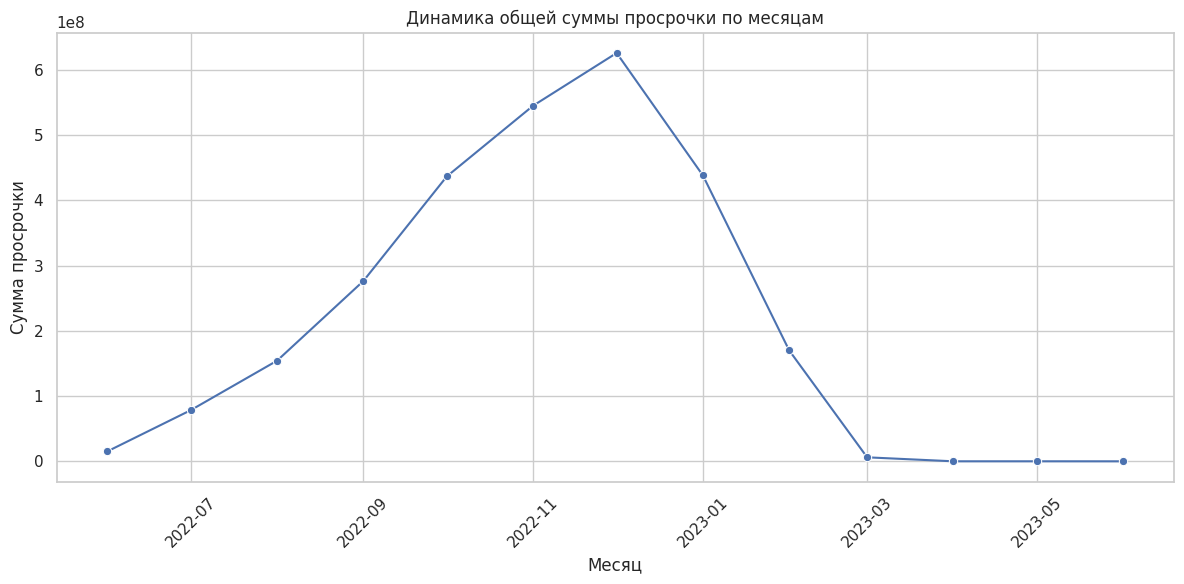

In [9]:
# Группируем по месяцу (plan_month) и считаем сумму просрочки
monthly_overdue = df.groupby('plan_month')['overdue'].sum().reset_index()

# Строим график
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_overdue, x='plan_month', y='overdue', marker='o')
plt.title('Динамика общей суммы просрочки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма просрочки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Находим минимальное и максимальное значение
min_val = monthly_overdue['overdue'].min()
max_val = monthly_overdue['overdue'].max()

# Находим соответствующие даты
min_date = monthly_overdue.loc[monthly_overdue['overdue'] == min_val, 'plan_month'].values[0]
max_date = monthly_overdue.loc[monthly_overdue['overdue'] == max_val, 'plan_month'].values[0]

# Считаем рост
growth_absolute = max_val - min_val
growth_percent = (growth_absolute / min_val) * 100 if min_val > 0 else float('inf')

# Выводим текст
print(f"Сумма просрочки выросла с {min_val:,.0f} руб. ({pd.to_datetime(min_date).strftime('%B %Y')}) "
      f"до {max_val:,.0f} руб. ({pd.to_datetime(max_date).strftime('%B %Y')}), "
      f"что составляет рост на {growth_absolute:,.0f} руб. ({growth_percent:.1f}%).")

Сумма просрочки выросла с 33,498 руб. (June 2023) до 625,632,850 руб. (December 2022), что составляет рост на 625,599,352 руб. (1867551.6%).


Вывод

График показывает, как менялась сумма просрочек по плановым платежам во времени. На основе этой динамики можно сделать вывод о том, растёт ли задолженность клиентов или снижается.

Обрати внимание на пики — они могут быть вызваны как реальными ухудшениями поведения клиентов, так и сбоями в платежах, которые стоит проанализировать отдельно.


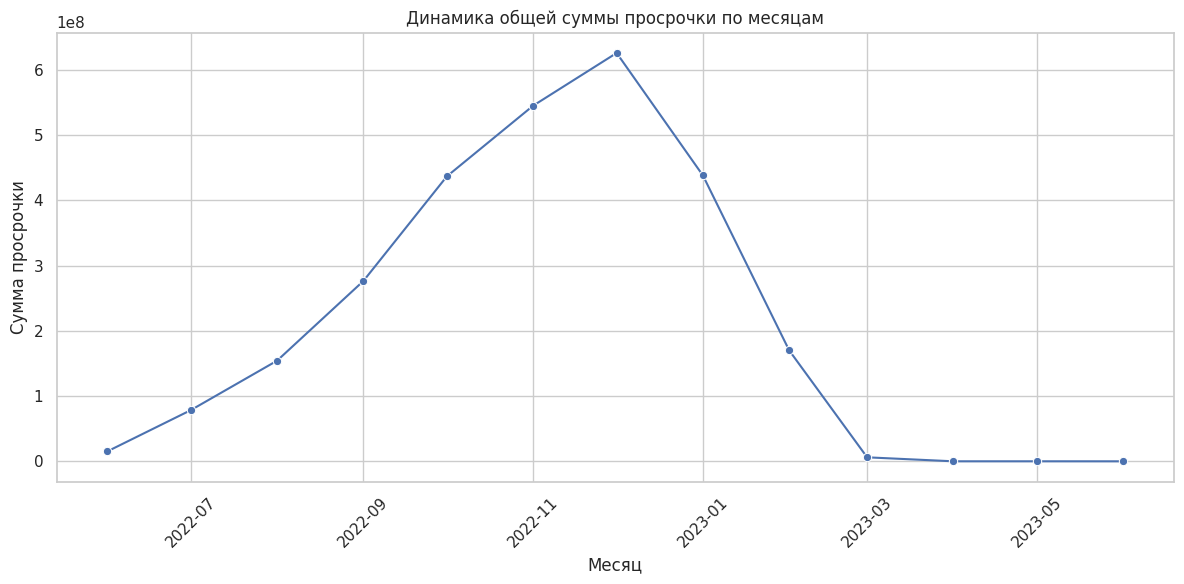

In [14]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_overdue, x='plan_month', y='overdue', marker='o')
plt.title('Динамика общей суммы просрочки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма просрочки')
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Сохраняем график как PDF
plt.savefig('overdue_trend.pdf', format='pdf', bbox_inches='tight')

plt.show()